## **Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import Required Libraries**

In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

## **Define Dataset Path**

In [3]:
dataset_dir = '/content/drive/MyDrive/colored_images'

##**Load Images & Display Class Names**



In [4]:
test_dir = keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

classes = os.listdir(dataset_dir)
print(f"Classes found: {classes}")


Found 1060 files belonging to 5 classes.
Classes found: ['Proliferate_DR', 'Mild', 'Severe', 'Moderate', 'No_DR']


### **Randomly Select a Class & Display Sample Images**

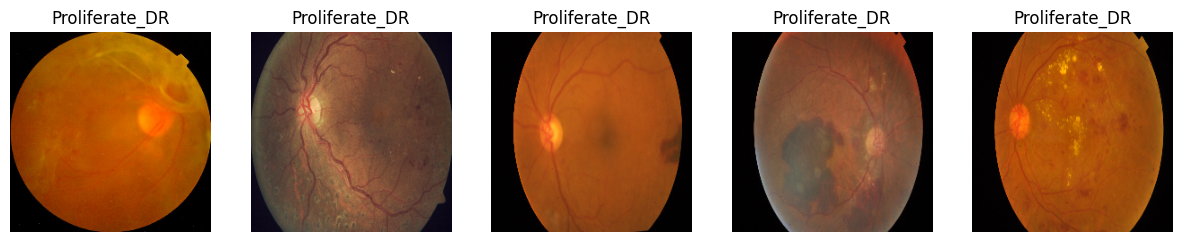

In [5]:
selected_class = random.choice(classes)
class_dir = os.path.join(dataset_dir, selected_class)

images = os.listdir(class_dir)
random_images = random.sample(images, min(5, len(images)))

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(class_dir, img_name)
    img = Image.open(img_path)

    plt.subplot(1, len(random_images), i + 1)
    plt.imshow(img)
    plt.title(selected_class)
    plt.axis('off')

plt.show()


## **Define Data Augmentation**

In [6]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

## **Load Training & Validation Datasets**

In [7]:
batch_size = 32
img_size = (224, 224)

train_dataset = keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_dataset = keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 1060 files belonging to 5 classes.
Using 848 files for training.
Found 1060 files belonging to 5 classes.
Using 212 files for validation.


## **MobileNetV2**

In [8]:
from tensorflow.keras.applications import MobileNetV2

img_size = (160, 160)
batch_size = 16

train_dataset = keras.utils.image_dataset_from_directory(
    dataset_dir, validation_split=0.2, subset="training", seed=123,
    image_size=img_size, batch_size=batch_size
)

val_dataset = keras.utils.image_dataset_from_directory(
    dataset_dir, validation_split=0.2, subset="validation", seed=123,
    image_size=img_size, batch_size=batch_size
)

class_names = train_dataset.class_names


Found 1060 files belonging to 5 classes.
Using 848 files for training.
Found 1060 files belonging to 5 classes.
Using 212 files for validation.


## **Prefetch Data for Faster Loading**

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


## **Define the Transfer Learning Model (MobileNetV2)**

In [10]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False  # Freeze pre-trained layers

model = keras.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **Compile & Train the Model**

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)


Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.6137 - loss: 0.9910 - val_accuracy: 0.8208 - val_loss: 0.3970
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8254 - loss: 0.4192 - val_accuracy: 0.8019 - val_loss: 0.4293
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7959 - loss: 0.4436 - val_accuracy: 0.8443 - val_loss: 0.3340
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8635 - loss: 0.3215 - val_accuracy: 0.8632 - val_loss: 0.3042
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.8352 - loss: 0.3220 - val_accuracy: 0.8208 - val_loss: 0.3218


## **Save the Trained Model**

In [12]:
model.save("/content/drive/MyDrive/diabetic_retinopathy_model.h5")


## **Evaluate Model Performance**

In [13]:
# Evaluate model on validation set
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7963 - loss: 0.3491
Validation Accuracy: 0.82


## **Upload & Test on a New Image**

In [14]:
from google.colab import files
uploaded = files.upload()

test_image_path = list(uploaded.keys())[0]


Saving 1a7e3356b39c.png to 1a7e3356b39c.png


### **Preprocess and Predict on New Image**

In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image

img = image.load_img(test_image_path, target_size=(160, 160))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
print(f"Predicted Class: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: No_DR


## **Display Prediction with Image**

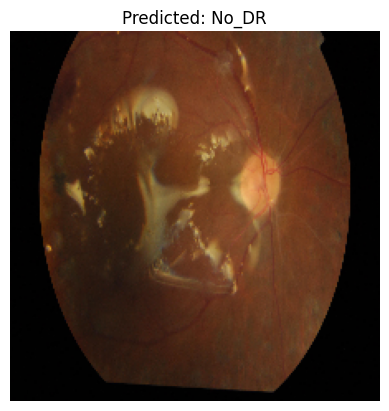

In [16]:
import matplotlib.pyplot as plt

plt.imshow(image.load_img(test_image_path))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()


# **ResNet50**

In [17]:
from tensorflow.keras.applications import ResNet50


img_size = (160, 160)
batch_size = 16

train_dataset = keras.utils.image_dataset_from_directory(
    dataset_dir, validation_split=0.2, subset="training", seed=123,
    image_size=img_size, batch_size=batch_size
)

val_dataset = keras.utils.image_dataset_from_directory(
    dataset_dir, validation_split=0.2, subset="validation", seed=123,
    image_size=img_size, batch_size=batch_size
)

class_names = train_dataset.class_names

# Load the ResNet50 model with pre-trained weights, excluding the top layer
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False  # Freeze pre-trained layers

# Build the model on top of ResNet50
model = keras.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)



Found 1060 files belonging to 5 classes.
Using 848 files for training.
Found 1060 files belonging to 5 classes.
Using 212 files for validation.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.3969 - loss: 1.2902 - val_accuracy: 0.5755 - val_loss: 0.9853
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5491 - loss: 1.0386 - val_accuracy: 0.5755 - val_loss: 0.9435
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5211 - loss: 1.0283 - val_accuracy: 0.6840 - val_loss: 0.9793
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5071 - loss: 0.9952 - val_accuracy: 0.5755 - val_loss: 0.9080
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.5537 - loss: 0.9396 - val_accuracy: 0.5755 - val_loss: 0.8868


In [19]:

# Save the model
model.save("/content/drive/MyDrive/diabetic_retinopathy_model_resnet50.h5")


In [20]:
# Evaluate model on validation set
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5379 - loss: 0.9109
Validation Accuracy: 0.58


In [21]:
# Code for prediction on a single uploaded image
from google.colab import files
uploaded = files.upload()

test_image_path = list(uploaded.keys())[0]  # Automatically set uploaded file path

Saving 000c1434d8d7.png to 000c1434d8d7.png


In [22]:
import numpy as np
from tensorflow.keras.preprocessing import image

img = image.load_img(test_image_path, target_size=(160, 160))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize

# Predict the class of the uploaded image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
print(f"Predicted Class: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: No_DR


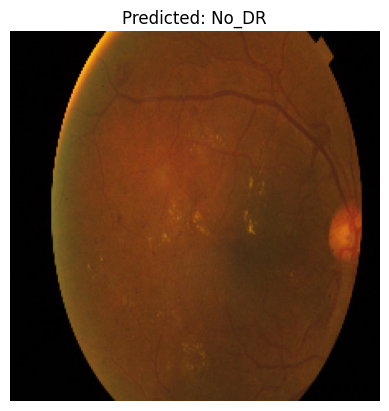

In [23]:
# Show the uploaded image along with the prediction
import matplotlib.pyplot as plt

plt.imshow(image.load_img(test_image_path))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

# **EfficientNetB0**

In [24]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

img_size = (160, 160)
batch_size = 16

# Load training and validation datasets
train_dataset = keras.utils.image_dataset_from_directory(
    dataset_dir, validation_split=0.2, subset="training", seed=123,
    image_size=img_size, batch_size=batch_size
)

val_dataset = keras.utils.image_dataset_from_directory(
    dataset_dir, validation_split=0.2, subset="validation", seed=123,
    image_size=img_size, batch_size=batch_size
)

class_names = train_dataset.class_names

# Load EfficientNetB0 with pre-trained ImageNet weights, excluding top layer
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(160, 160, 3))
base_model.trainable = False  # Freeze the base model

# Define the model architecture
model = keras.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Found 1060 files belonging to 5 classes.
Using 848 files for training.
Found 1060 files belonging to 5 classes.
Using 212 files for validation.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 258ms/step - accuracy: 0.3953 - loss: 1.2615 - val_accuracy: 0.5755 - val_loss: 0.9905
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5098 - loss: 1.0842 - val_accuracy: 0.5755 - val_loss: 1.0324
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.4992 - loss: 1.0714 - val_accuracy: 0.5755 - val_loss: 0.9746
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5358 - loss: 1.0475 - val_accuracy: 0.5755 - val_loss: 0.9780
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.5369 - loss: 1.0327 - val_accuracy: 0.5755 - val_loss: 0.9750


In [26]:
# Save the trained model
model.save("/content/drive/MyDrive/diabetic_retinopathy_model_efficientnetb0.h5")

In [27]:
# Evaluate model on validation set
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5379 - loss: 0.9990
Validation Accuracy: 0.58


In [28]:
# Upload and predict on a new image
from google.colab import files
uploaded = files.upload()

test_image_path = list(uploaded.keys())[0]  # Get uploaded image filename

Saving 0bf37ca3156a.png to 0bf37ca3156a.png


In [29]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Preprocess the uploaded image
img = image.load_img(test_image_path, target_size=(160, 160))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize

# Predict using the trained model
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
print(f"Predicted Class: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: No_DR


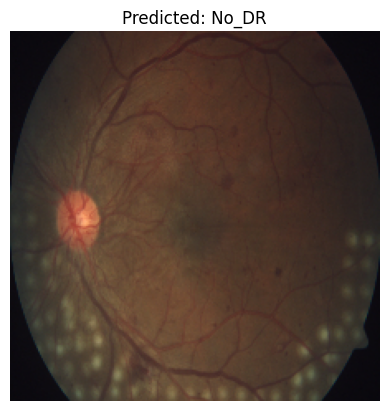

In [30]:
# Display the uploaded image with the prediction
import matplotlib.pyplot as plt

plt.imshow(image.load_img(test_image_path))
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

## Model Comparision

In [31]:
def build_model(base_model, class_names):
    base_model.trainable = False
    model = tf.keras.Sequential([
        layers.Rescaling(1./255),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(len(class_names), activation="softmax")
    ])
    return model


In [32]:

# Assuming you want to test EfficientNetB0, ResNet50, and MobileNetV2
models_to_test = {
    "EfficientNetB0": EfficientNetB0(weights="imagenet", include_top=False, input_shape=(160, 160, 3)),
    "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=(160, 160, 3)),
    "MobileNetV2": MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3)),
}

results = {}

for name, base_model in models_to_test.items():
    print(f"\nTraining model: {name}")
    model = build_model(base_model, class_names)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=5,
        verbose=1
    )

    loss, accuracy = model.evaluate(val_dataset, verbose=0)
    results[name] = {
        "val_accuracy": round(accuracy, 4),
        "val_loss": round(loss, 4)
    }



Training model: EfficientNetB0
Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 250ms/step - accuracy: 0.4692 - loss: 1.1832 - val_accuracy: 0.5755 - val_loss: 0.9800
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.4957 - loss: 1.0747 - val_accuracy: 0.5755 - val_loss: 1.0160
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.4351 - loss: 1.1183 - val_accuracy: 0.5755 - val_loss: 0.9721
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.5231 - loss: 1.0297 - val_accuracy: 0.5755 - val_loss: 1.0150
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.4968 - loss: 1.0345 - val_accuracy: 0.5755 - val_loss: 0.9820

Training model: ResNet50
Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.4507 - loss: 1.1625 - val_accuracy: 0.5755 - val_loss: 0.9484
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.5246 - loss: 1.0167 - val_accuracy: 0.5755 - val_loss: 0.9504
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - acc

In [33]:
for model_name, metrics in results.items():
    print(f"{model_name}: Accuracy = {metrics['val_accuracy']}, Loss = {metrics['val_loss']}")


EfficientNetB0: Accuracy = 0.5755, Loss = 0.982
ResNet50: Accuracy = 0.5755, Loss = 0.8754
MobileNetV2: Accuracy = 0.8302, Loss = 0.2938


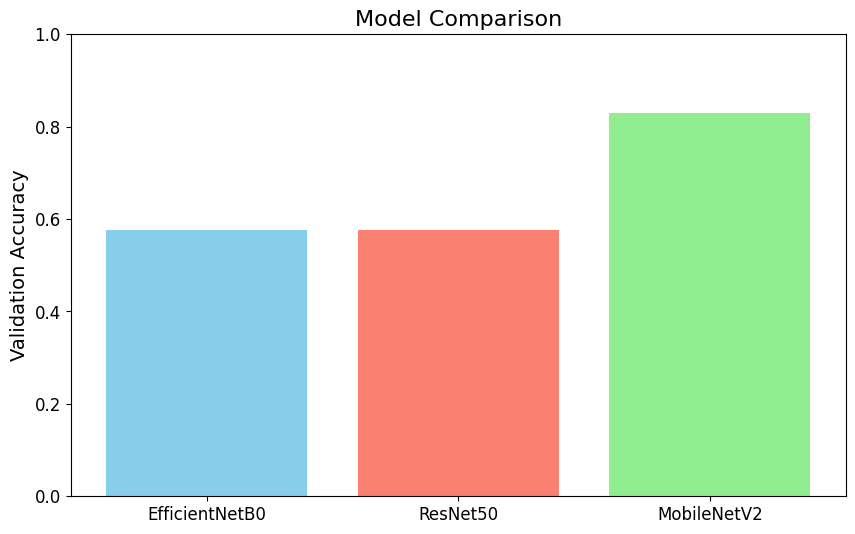

In [34]:
import matplotlib.pyplot as plt

model_names = list(results.keys())
accuracies = [results[m]["val_accuracy"] for m in model_names]

plt.figure(figsize=(10, 6))  # Increase the plot size here
plt.bar(model_names, accuracies, color=["skyblue", "salmon", "lightgreen"])
plt.ylabel("Validation Accuracy", fontsize=14)
plt.title("Model Comparison", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [35]:
pip install gradio


In [36]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

# Load all 3 trained models
efficientnet_model = load_model("/content/drive/MyDrive/diabetic_retinopathy_model_efficientnetb0.h5")
resnet_model = load_model("/content/drive/MyDrive/diabetic_retinopathy_model_resnet50.h5")
mobilenet_model = load_model("/content/drive/MyDrive/diabetic_retinopathy_model.h5")

# Store models and names
models = [
    ("EfficientNetB0", efficientnet_model),
    ("ResNet50", resnet_model),
    ("MobileNetV2", mobilenet_model)
]

# Define your class names (same for all models)
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR']  # Update to your actual class list

# Model index tracker
model_index = 0

# Prediction function with model rotation
def predict_image(img: Image.Image):
    global model_index

    model_name, model = models[model_index]
    model_index = (model_index + 1) % len(models)  # Rotate to next model

    # Preprocess image
    img = img.resize((160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    probs = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
    top_class = max(probs, key=probs.get)

    return f"Model: {model_name} ➜ Prediction: {top_class}", probs

# Build Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=[
        gr.Textbox(label="Model Used & Predicted Class"),
        gr.Label(num_top_classes=3, label="Class Probabilities")
    ],
    title="🧠 Diabetic Retinopathy Classifier (Model Rotator)",
    description="Each time you upload an image, a different model (EfficientNetB0, ResNet50, or MobileNetV2) will make a prediction."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1a5fb6f0bc27fa0846.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
